name : Tom LAURENT-GUCKER

# Intro to GLM Analysis: a single-session, single-subject fMRI dataset

For this part of the notebook we will firstly play, with the occurency of events by creating random onset times. Even if the duration will be the same we will except to get a much more unpredictive response since onset times don't occure periodicly.

Let's get into it:

In [ ]:
!pip install nilearn


from nilearn.datasets import fetch_spm_auditory

subject_data = fetch_spm_auditory()
print(*subject_data.func[:5], sep="\n")  # print paths of first 5 func images

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 19.2 MB/s eta 0:00:00

Dataset created in /root/nilearn_data/spm_auditory

Data absent, downloading...


Downloaded 31465472 of 34212021 bytes (92.0%,    0.6s remaining) ...done. (8 seconds, 0 min)
Extracting data from /root/nilearn_data/spm_auditory/sub001/MoAEpilot.zip..... done.


/root/nilearn_data/spm_auditory/sub001/fM00223/fM00223_004.img
/root/nilearn_data/spm_auditory/sub001/fM00223/fM00223_005.img
/root/nilearn_data/spm_auditory/sub001/fM00223/fM00223_006.img
/root/nilearn_data/spm_auditory/sub001/fM00223/fM00223_007.img
/root/nilearn_data/spm_auditory/sub001/fM00223/fM00223_008.img


We can display the first functional image and the subject's anatomy:



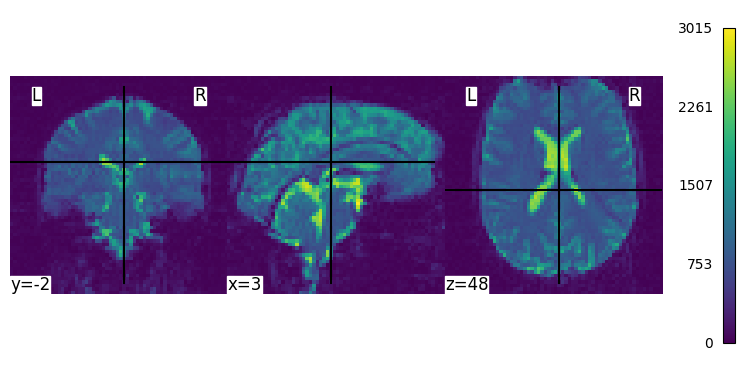

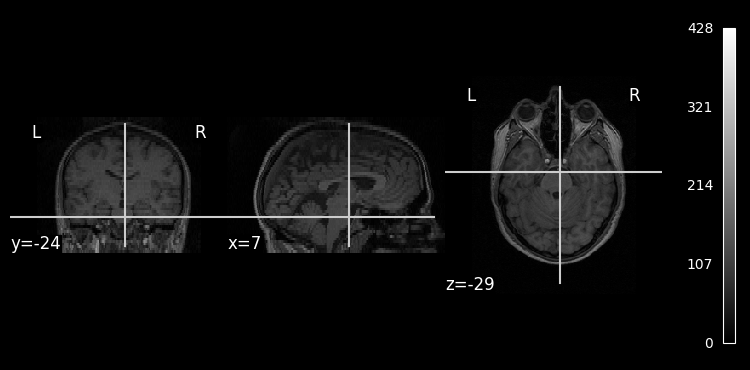

In [ ]:
from nilearn.plotting import plot_anat, plot_img, plot_stat_map

plot_img(subject_data.func[0], colorbar=True, cbar_tick_format="%i")
plot_anat(subject_data.anat, colorbar=True, cbar_tick_format="%i")

Next, we concatenate all the 3D :term:`EPI` image into a single 4D image,
then we average them in order to create a background
image that will be used to display the activations:



In [ ]:
from nilearn.image import concat_imgs, mean_img

fmri_img = concat_imgs(subject_data.func)
mean_img = mean_img(fmri_img)

## So from the code cells above :

We go over the procedure for locating and getting ready for analysis brain imaging data. We download and load data from auditory stimulation trials using the nilearn library, making sure that the Brain Imaging Data Structure (BIDS) is followed.

To get a sense of the type of data we are working with, we first print the paths of the functional photos and display the first functional image next to the subject's anatomy.

We can then move on to data processing steps :

We concatenate 3D functional images into a 4D image and create a mean image for background use in displaying activations further in the study. Regarding dimensions, the 4th one that we add is to add a time-dimension.

Next, we turn our attention to defining the experimental paradigm. Using the pandas library, we read data from an events.tsv file that includes information on trial kinds, rest intervals, and the timing of audio stimulation. Understanding the experimental design requires an understanding of this file. All in all, we organize the data and provide pertinent information about the experimental setting, laying the foundation for further research.

## Specifying the experimental paradigm

We must now provide a description of the experiment, that is, define the
timing of the auditory stimulation and rest periods. This is typically
provided in an events.tsv file. The path of this file is
provided in the dataset.



In [ ]:
import pandas as pd

events = pd.read_table(subject_data["events"])
events

,onset,duration,trial_type
0,0.0,42.0,rest
1,42.0,42.0,active
2,84.0,42.0,rest
3,126.0,42.0,active
4,168.0,42.0,rest
5,210.0,42.0,active
6,252.0,42.0,rest
7,294.0,42.0,active
8,336.0,42.0,rest
9,378.0,42.0,active


Now let's visualize more clearly the column events before adding modifications :

In [ ]:
events = pd.read_table(subject_data["events"])

print(events.columns)
print(events['onset'])

Index(['onset', 'duration', 'trial_type'], dtype='object')
0       0.0
1      42.0
2      84.0
3     126.0
4     168.0
5     210.0
6     252.0
7     294.0
8     336.0
9     378.0
10    420.0
11    462.0
12    504.0
13    546.0
14    588.0
15    630.0
Name: onset, dtype: float64


In [ ]:
import numpy as np
import random

np.random.seed(352)
#I fixed my seed so you can get the same values as me for the rest of the notebook

#we fix a final value and assure that we are not going to  deal with negative values it would not make sense since it's time
max_value = 800
random_values = np.random.uniform(0, max_value, size=16).astype('float64')

#we then sort in ascending order
random_values.sort()

#we create a new tab as copy of event then we change the onset column with our new random values
new_tab = events.copy()
new_tab['onset'] = random_values

#finaly we print the data
new_tab

,onset,duration,trial_type
0,15.435349,42.0,rest
1,33.945085,42.0,active
2,80.653857,42.0,rest
3,95.625095,42.0,active
4,164.938994,42.0,rest
5,185.397710,42.0,active
6,281.807360,42.0,rest
7,324.386580,42.0,active
8,335.373608,42.0,rest
9,388.124569,42.0,active


## Performing the GLM analysis

It is now time to create and estimate a ``FirstLevelModel`` object,
that will generate the *design matrix*
using the information provided by both events and new_tab object.

Let's keep the parameters of the first-level model

* t_r=7(s) is the time of repetition of acquisitions
* noise_model='ar1' specifies the noise covariance model: a lag-1 dependence
* standardize=False means that we do not want
  to rescale the time series to mean 0, variance 1
* hrf_model='spm' means that we rely on the SPM "canonical hrf" model
  (without time or dispersion derivatives)
* drift_model='cosine' means that we model the signal drifts
  as slow oscillating time functions
* high_pass=0.01(Hz) defines the cutoff frequency
  (inverse of the time period).



In [ ]:
from nilearn.glm.first_level import FirstLevelModel

fmri_glm = FirstLevelModel(
    t_r=7,
    noise_model="ar1",
    standardize=False,
    hrf_model="spm",
    drift_model="cosine",
    high_pass=0.01,
)

fmri_glm_c = FirstLevelModel(
    t_r=7,
    noise_model="ar1",
    standardize=False,
    hrf_model="spm",
    drift_model="cosine",
    high_pass=0.01,
)

Now that we have specified the model, we can run it on both tab



In [ ]:
fmri_glm = fmri_glm.fit(fmri_img, events)
fmri_glm_c = fmri_glm_c.fit(fmri_img, new_tab)

One can inspect the design matrix (rows represent time, and
columns contain the predictors).



In [ ]:
design_matrix = fmri_glm.design_matrices_[0]
design_matrix_c = fmri_glm_c.design_matrices_[0]

<Figure size 800x400 with 0 Axes>

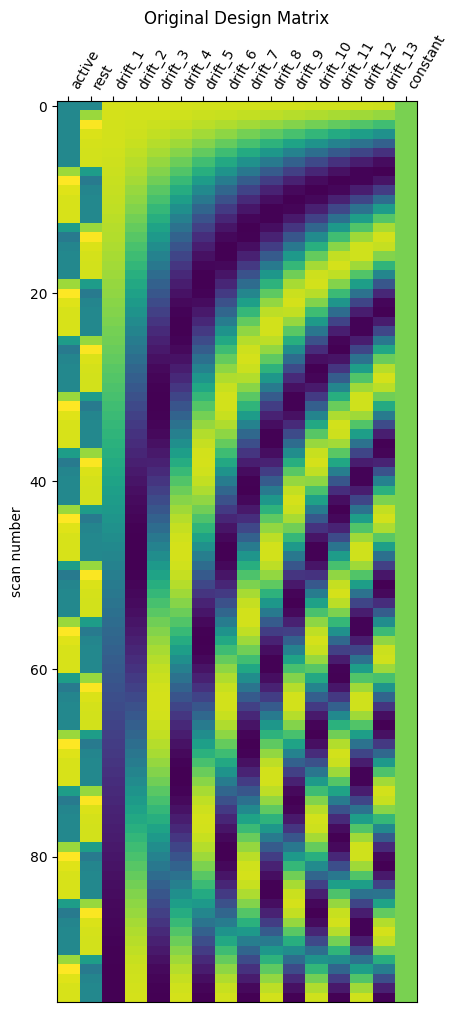

<Figure size 800x400 with 0 Axes>

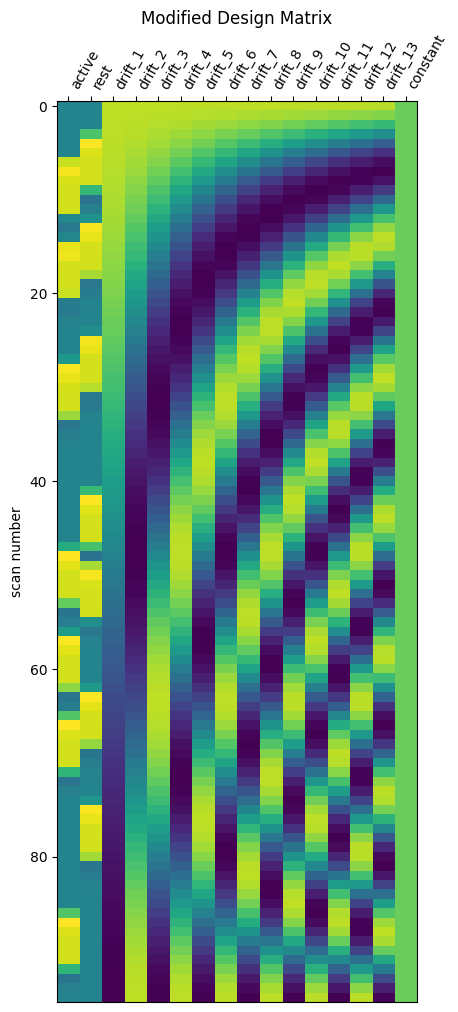

In [ ]:
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix

# Plot the original design matrix
plt.figure(figsize=(8, 4))
plot_design_matrix(design_matrix)
plt.title('Original Design Matrix')
plt.show()

# Plot the modified design matrix
plt.figure(figsize=(8, 4))
plot_design_matrix(design_matrix_c)
plt.title('Modified Design Matrix')
plt.show()

Now let's inspect and compare the auditory response patterns in the "active" condition between the two design matrices.

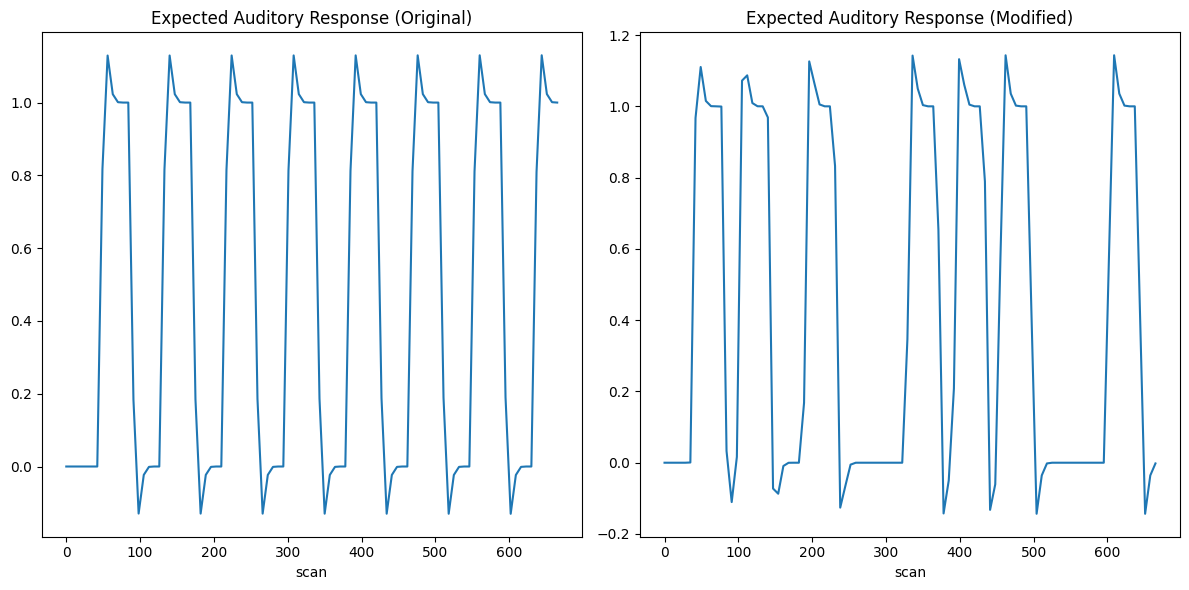

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(design_matrix["active"])
plt.xlabel("scan")
plt.title("Expected Auditory Response (Original)")

# Plot the expected auditory response for the modified design matrix
plt.subplot(1, 2, 2)
plt.plot(design_matrix_c["active"])  # Assuming fmri_glm_c is already fitted
plt.xlabel("scan")
plt.title("Expected Auditory Response (Modified)")

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()

As expected we get a much more chaotic response with modified one since we don't have a periodic data, we can even get overlapping events

In [ ]:
import numpy as np

conditions = {"active": np.zeros(16), "rest": np.zeros(16)}
conditions["active"][0] = 1
conditions["rest"][1] = 1

In [ ]:
active_minus_rest = conditions["active"] - conditions["rest"]

Let's look at it: plot the coefficients of the :term:`contrast`, indexed by
the names of the columns of the design matrix.



<Axes: label='conditions'>

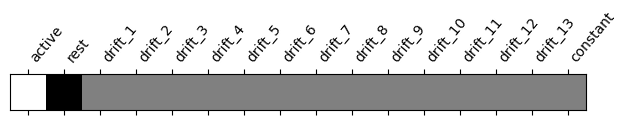

In [ ]:
from nilearn.plotting import plot_contrast_matrix

plot_contrast_matrix(active_minus_rest, design_matrix=design_matrix)

<Axes: label='conditions'>

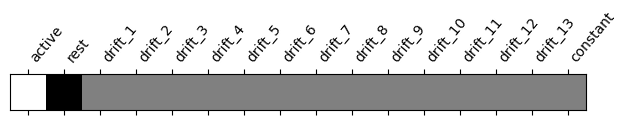

In [ ]:
plot_contrast_matrix(active_minus_rest, design_matrix=design_matrix_c)

In [ ]:
eff_map = fmri_glm.compute_contrast(
    active_minus_rest, output_type="effect_size"
)

eff_map_c = fmri_glm_c.compute_contrast(
    active_minus_rest, output_type="effect_size"
)

In [ ]:
z_map = fmri_glm.compute_contrast(active_minus_rest, output_type="z_score")
z_map_c = fmri_glm_c.compute_contrast(active_minus_rest, output_type="z_score")

## Plot thresholded z scores map

Let's display both "normal" conditions and "modified" ones to results and compare we will the same orders for threshold different values



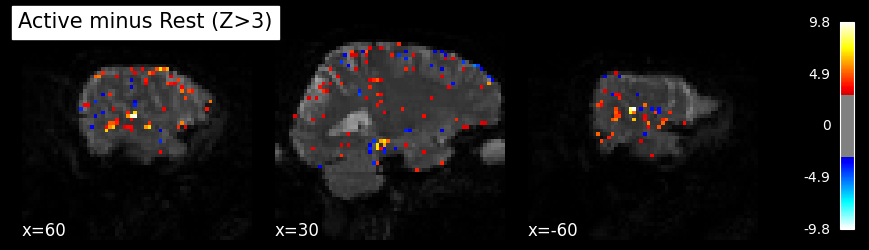

In [ ]:
plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=3.0,
    display_mode="x",
    cut_coords=3,
    black_bg=True,
    title="Active minus Rest (Z>3)",
)
plt.show()

In relation to this first figure and for the rest, the coloured markings vary from blue to red; blue indicates reduced activity in the area compared with its 'resting' state during a period of listening, and red indicates increased activity.

With the parameters chosen here, the regions marked in red are those where activity is higher in the active state than in the resting state, with a Z value greater than 3.

We can thus deduce which brain regions are significantly more active during the active state compared with the resting state.

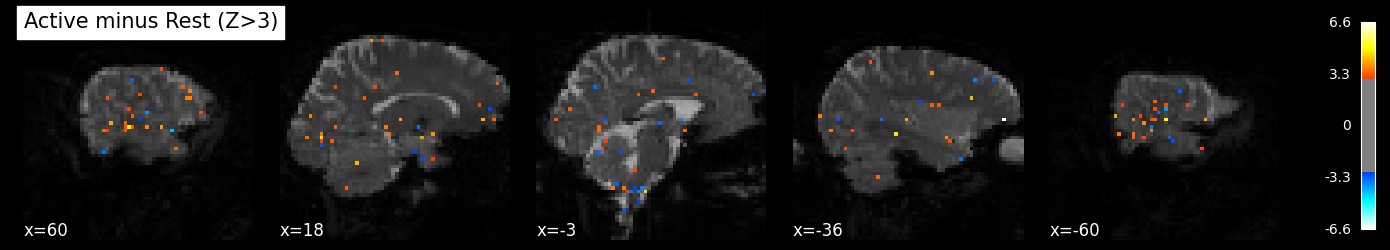

In [ ]:
plot_stat_map(
    z_map_c,
    bg_img=mean_img,
    threshold=3,
    display_mode="x",
    cut_coords=5,
    black_bg=True,
    title="Active minus Rest (Z>3)",
)
plt.show()

For this plot I've added more cut-outs for better visualisation.
The coloured spots vary from blue to yellow, indicating different intensities of activity that have been detected. However, given that our data was randomly generated, these coloured spots could well represent false positives, in other words regions appearing as significantly active or at rest simply because of the random noise in the data.

Now that we have seen normal conditions vs altered ones let's change some values and display only the altered one to prove the point of Bennett:

Uncorrected p<0.001 threshold: 3.291


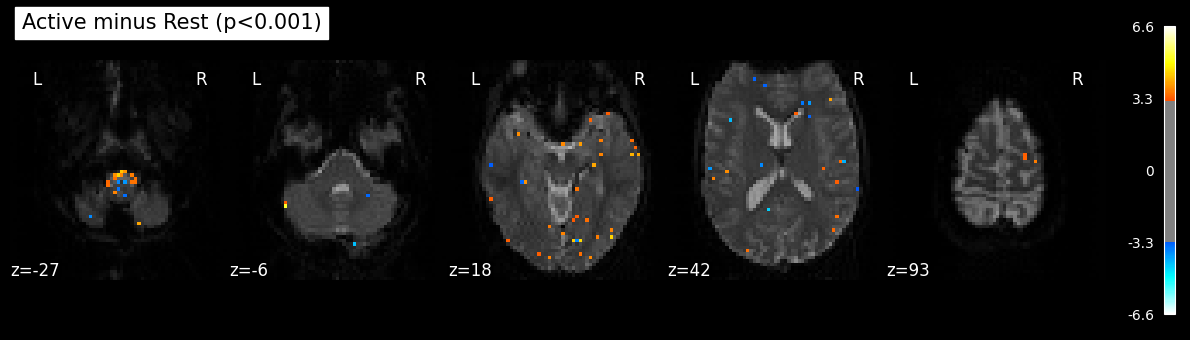

In [ ]:
from nilearn.glm import threshold_stats_img

_, threshold = threshold_stats_img(z_map_c, alpha=0.001, height_control="fpr")
print(f"Uncorrected p<0.001 threshold: {threshold:.3f}")
plot_stat_map(
    z_map_c,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=5,
    black_bg=True,
    title="Active minus Rest (p<0.001)",
)
plt.show()

Instead of using a fixed threshold of three as in the previous plot, a false positive rate (fpr) of 0.001 was used to create this new one. Compared to the previous figure, we can observe that there are less colored patches (which indicate considerable activity) in the new plot. This implies that fewer false positives have occurred as a result of using an altered threshold. Still, there are occasional false positives, as was previously indicated. Since the threshold we employed is predicated on a false positive rate of 0.001, approximately 0.1% of tests may still result in false positives.

Bonferroni-corrected, p<0.05 threshold: 4.934


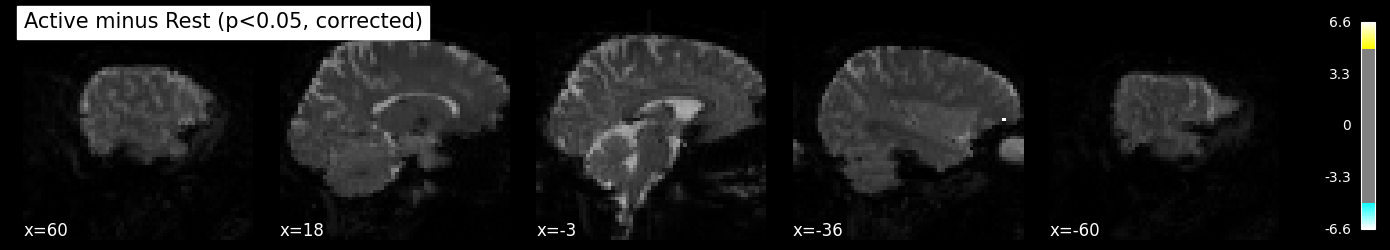

In [ ]:
_, threshold = threshold_stats_img(
    z_map_c, alpha=0.05, height_control="bonferroni"
)
print(f"Bonferroni-corrected, p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    z_map_c,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="x",
    cut_coords=5,
    black_bg=True,
    title="Active minus Rest (p<0.05, corrected)",
)
plt.show()

With this new plot, we apply a Bonferroni correction to our data with a significance threshold of 0.05. The calculated threshold then becomes 4.934. The number of false positives has been further reduced compared with the previous plot, with only one present in the x=-36 slice.

As Bennett demonstrated, the Bonferroni correction is often considered too conservative, as it can lead to a high rate of type II errors.

False Discovery rate = 0.05 threshold: 3.867


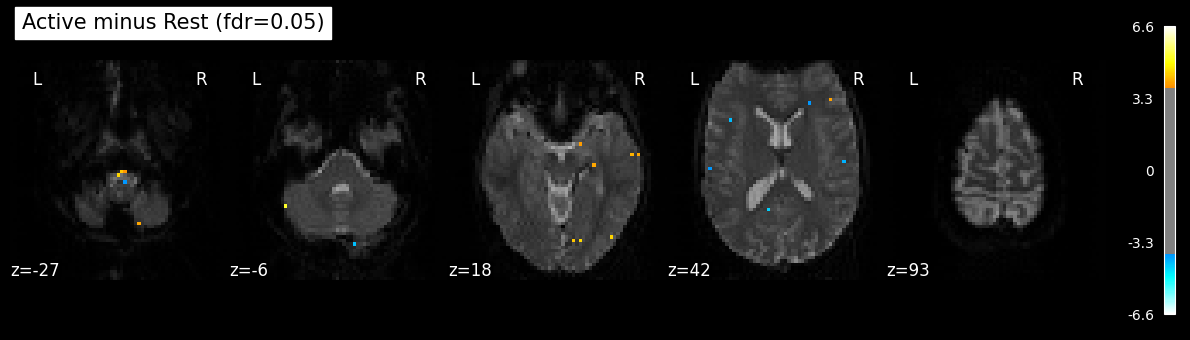

In [ ]:
_, threshold = threshold_stats_img(z_map_c, alpha=0.05, height_control="fdr")
print(f"False Discovery rate = 0.05 threshold: {threshold:.3f}")
plot_stat_map(
    z_map_c,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=5,
    black_bg=True,
    title="Active minus Rest (fdr=0.05)",
)
plt.show()

The data in this new figure were subjected to a false discovery rate (FDR) correction at a significance level of 0.05.
This means that we can accept that about 5% of the results that are deemed significant are false positives at the significance threshold of 0.05.
We notice multiple colored zones (representing strong activity) when we look at the new plot. This implies that a sizable proportion of false positives are found even when an FDR adjustment is applied.

/usr/local/lib/python3.10/dist-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(


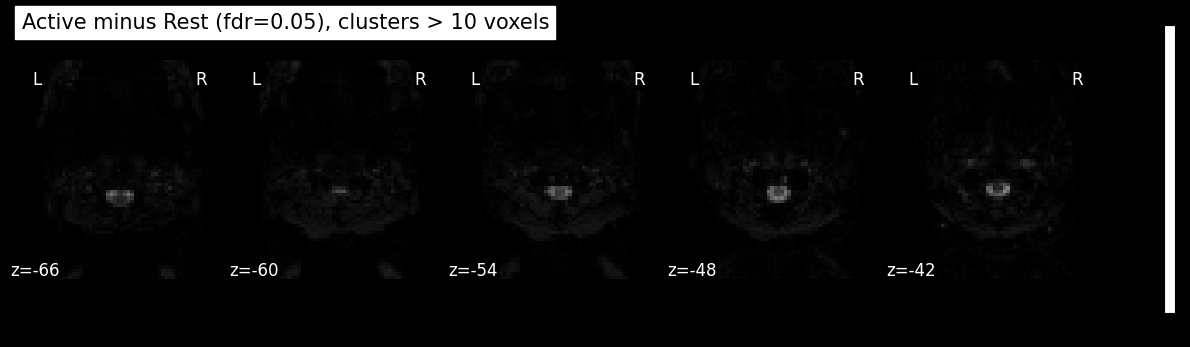

In [ ]:
clean_map, threshold = threshold_stats_img(
    z_map_c, alpha=0.05, height_control="fdr", cluster_threshold=10
)
plot_stat_map(
    clean_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=5,
    black_bg=True,
    title="Active minus Rest (fdr=0.05), clusters > 10 voxels",
)
plt.show()

Here we can see that every voxels has been eliminated, mostly because all of them were isolated.

To conclude this first part, after altering our initial data, we first used a fixed threshold to visualise the data, which led to a significant number of false positives.
Then, after applying a Bonferroni correction, which is a more conservative method for controlling false positives, and later an FDR method. We observed a reduction in the number of false positives. However, even with the FDR correction, we still observed the presence of false positives. Stressing that even with corrections for multiple comparisons, it is still possible to observe false positives due to random noise in the data.

This experiment highlights the same conclusion as Bennett's experiment: the importance of using appropriate correction methods for multiple comparisons when analysing fMRI data. It also demonstrates that different correction methods can have different results, and that it is crucial to choose the most appropriate method for our specific analysis.

# Part 2 : smoothing temporal series

To smoth time series let's use the smoothed_img function provided by nilearn library, I will explain further in the notebook what we are doing with some visualization :

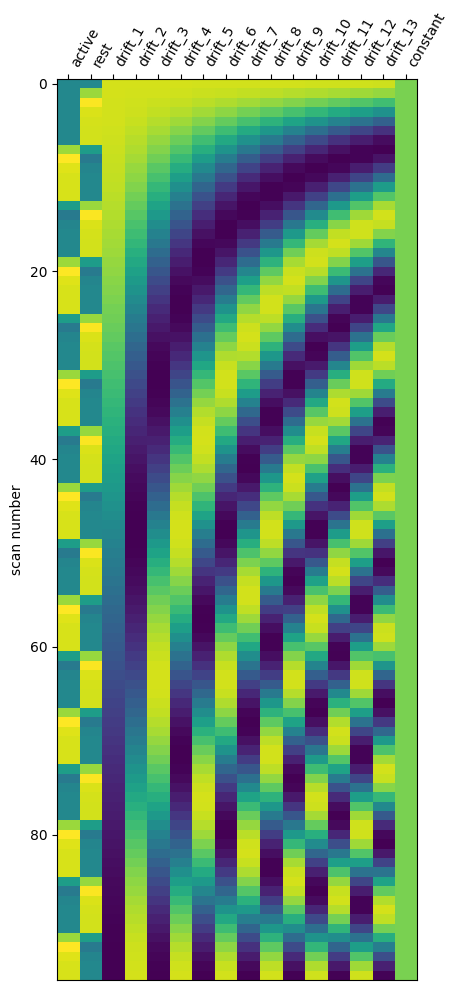

In [ ]:
from nilearn.image import smooth_img

smoothed_img = smooth_img(fmri_img, fwhm=1)  # Change fwhm value as needed

# Then use smoothed_img in your pipeline
fmri_glm = fmri_glm.fit(smoothed_img, events)

design_matrix = fmri_glm.design_matrices_[0]

import matplotlib.pyplot as plt

from nilearn.plotting import plot_design_matrix

plot_design_matrix(design_matrix)

plt.show()

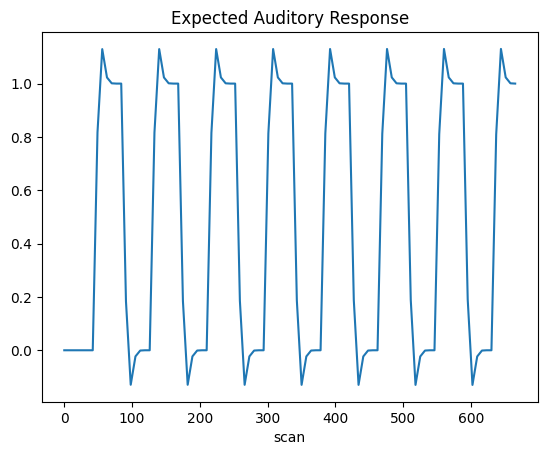

In [ ]:
plt.plot(design_matrix["active"])
plt.xlabel("scan")
plt.title("Expected Auditory Response")
plt.show()

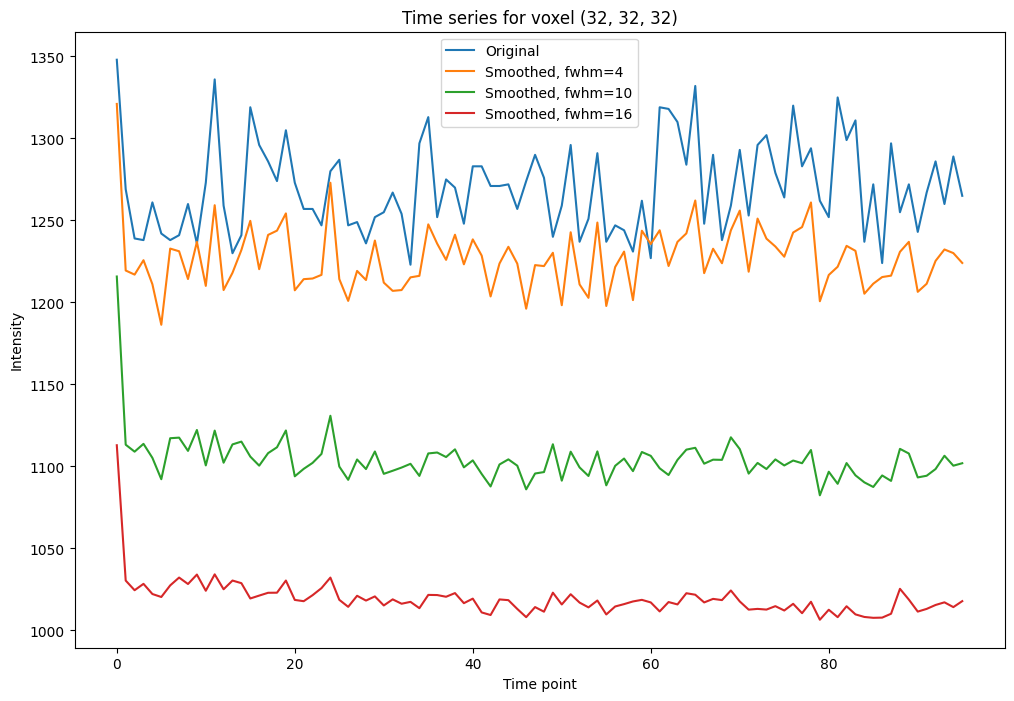

In [ ]:
import matplotlib.pyplot as plt
from nilearn.image import index_img

# Choose a voxel to inspect (this is just an example, you might want to choose a different voxel)
voxel_index = (32, 32, 32)

# Extract the time series for this voxel from the original and smoothed images
original_time_series = fmri_img.get_fdata()[voxel_index]
smoothed_img_4 = smooth_img(fmri_img, fwhm=4)
smoothed_img_10 = smooth_img(fmri_img, fwhm=10)
smoothed_img_16 = smooth_img(fmri_img, fwhm=16)
smoothed_time_series_4 = smoothed_img_4.get_fdata()[voxel_index]
smoothed_time_series_10 = smoothed_img_10.get_fdata()[voxel_index]
smoothed_time_series_16 = smoothed_img_16.get_fdata()[voxel_index]

# Plot the time series
plt.figure(figsize=(12, 8))
plt.plot(original_time_series, label='Original')
plt.plot(smoothed_time_series_4, label='Smoothed, fwhm=4')
plt.plot(smoothed_time_series_10, label='Smoothed, fwhm=10')
plt.plot(smoothed_time_series_16, label='Smoothed, fwhm=16')
plt.legend()
plt.title('Time series for voxel {}'.format(voxel_index))
plt.xlabel('Time point')
plt.ylabel('Intensity')
plt.show()


So to explain what we are doing here it we are applying these steps :

1.   We extract the time series data for the specified voxel from the original fMRI image.
2.   We apply Gaussian smoothing to the original fMRI image with the smooth_img function.
3. To get a better idea of how changing the scale change the results, we are using three different full width at half maximum (FWHM) values: 4, 10, and 16. Therefore it will result in three different smoothed images.
4. Finaly we plot the time series data from the original image and the three smoothed images on the same graph.

What can we see form this plot ?

First of all, the plot displays four lines: one line representing the original time series and one line representing each smoothed time series with various fmwh values.
The time points are shown by the x-axis, and each time point's voxel intensity is shown by the y-axis.
We can observe how the smoothing impacts the time series data by looking at the plot. In comparison to the original line, the smoothed lines are less noisy, have fewer value fluctuations, and are smoother as a whole. We can see that the smoother the time series is, the higher the fwhm value grows.

Now let's plot with our previous methods and see impacts on plots:

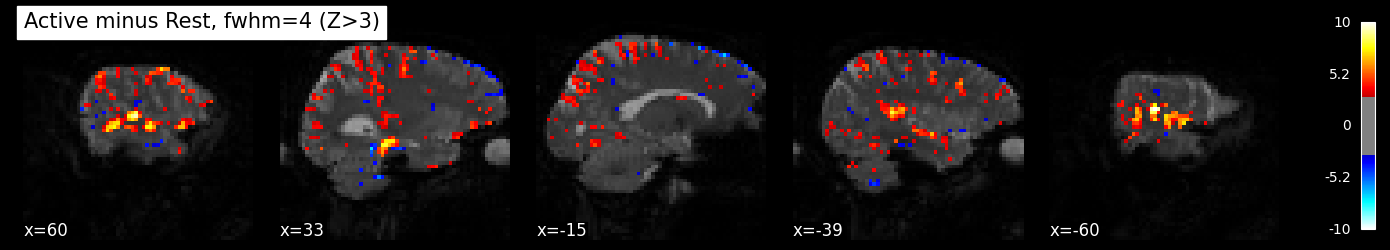

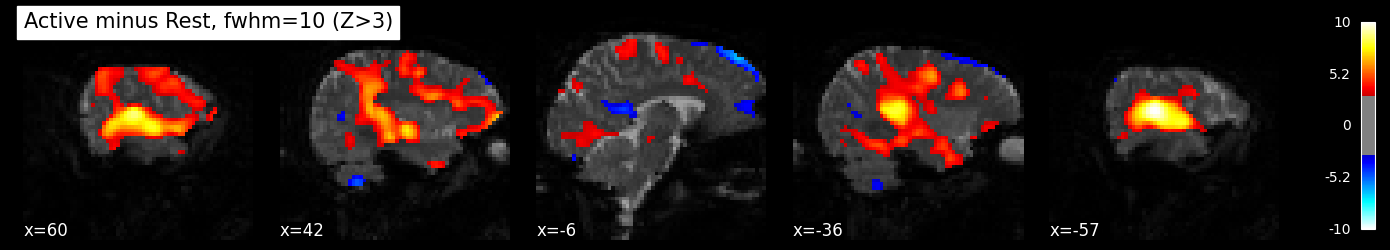

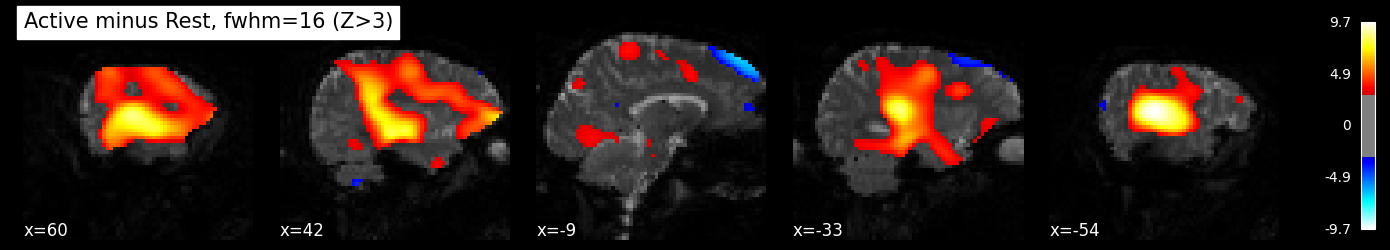

In [ ]:
from nilearn.plotting import plot_stat_map

# Compute the contrast for each smoothed image
z_map_4 = fmri_glm.fit(smoothed_img_4, events).compute_contrast(active_minus_rest, output_type="z_score")
z_map_10 = fmri_glm.fit(smoothed_img_10, events).compute_contrast(active_minus_rest, output_type="z_score")
z_map_16 = fmri_glm.fit(smoothed_img_16, events).compute_contrast(active_minus_rest, output_type="z_score")

# Plot the contrast maps
plot_stat_map(
    z_map_4,
    bg_img=mean_img,
    threshold=3,
    display_mode="x",
    cut_coords=5,
    black_bg=True,
    title="Active minus Rest, fwhm=4 (Z>3)",
)
plt.show()

plot_stat_map(
    z_map_10,
    bg_img=mean_img,
    threshold=3,
    display_mode="x",
    cut_coords=5,
    black_bg=True,
    title="Active minus Rest, fwhm=10 (Z>3)",
)
plt.show()

plot_stat_map(
    z_map_16,
    bg_img=mean_img,
    threshold=3,
    display_mode="x",
    cut_coords=5,
    black_bg=True,
    title="Active minus Rest, fwhm=16 (Z>3)",
)
plt.show()


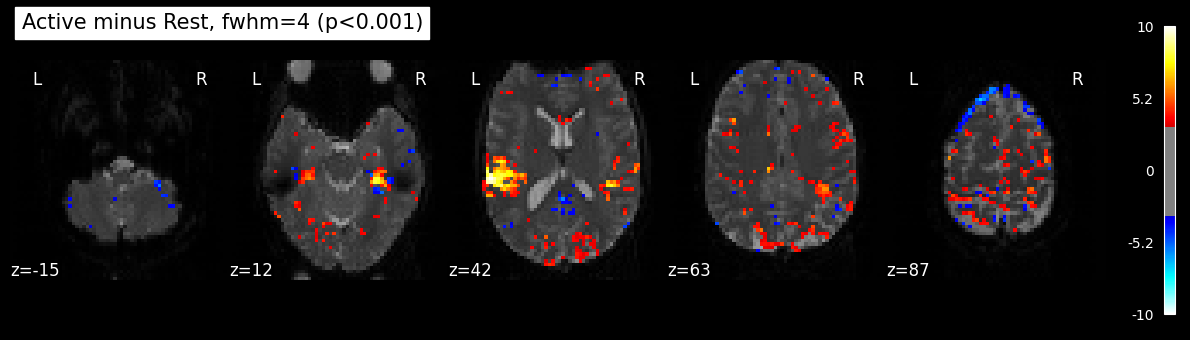

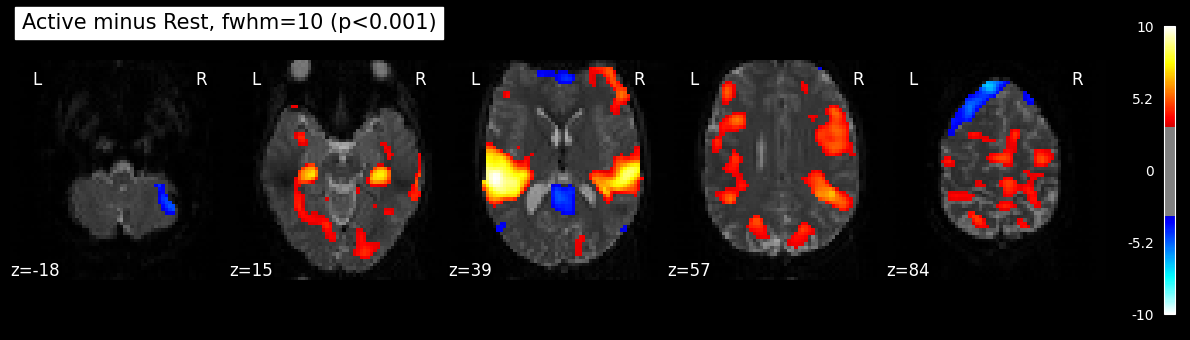

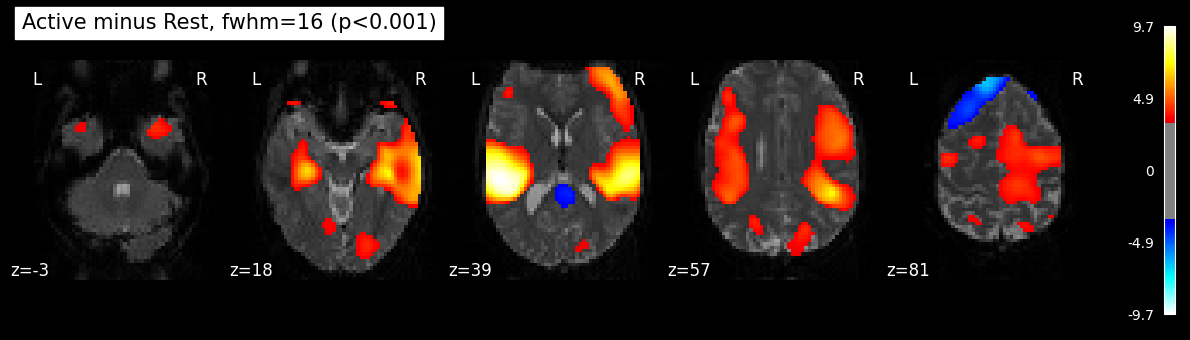

In [ ]:
# Determine the threshold for each contrast map
_, threshold_4 = threshold_stats_img(z_map_4, alpha=0.001, height_control="fpr")
_, threshold_10 = threshold_stats_img(z_map_10, alpha=0.001, height_control="fpr")
_, threshold_16 = threshold_stats_img(z_map_16, alpha=0.001, height_control="fpr")

# Plot the contrast maps
plot_stat_map(
    z_map_4,
    bg_img=mean_img,
    threshold=threshold_4,
    display_mode="z",
    cut_coords=5,
    black_bg=True,
    title="Active minus Rest, fwhm=4 (p<0.001)",
)
plt.show()

plot_stat_map(
    z_map_10,
    bg_img=mean_img,
    threshold=threshold_10,
    display_mode="z",
    cut_coords=5,
    black_bg=True,
    title="Active minus Rest, fwhm=10 (p<0.001)",
)
plt.show()

plot_stat_map(
    z_map_16,
    bg_img=mean_img,
    threshold=threshold_16,
    display_mode="z",
    cut_coords=5,
    black_bg=True,
    title="Active minus Rest, fwhm=16 (p<0.001)",
)
plt.show()

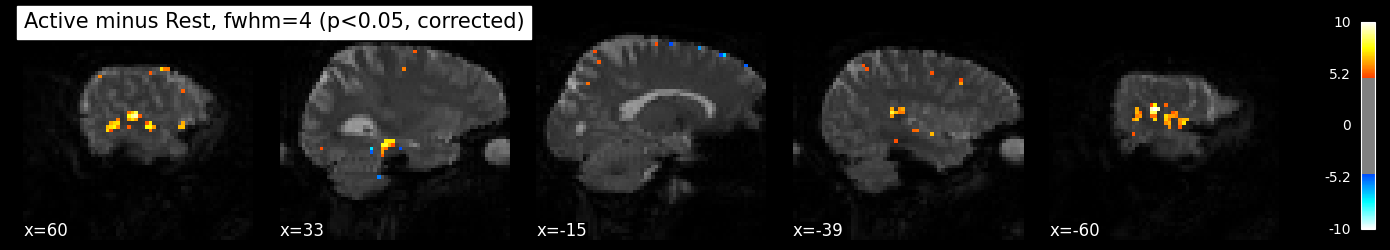

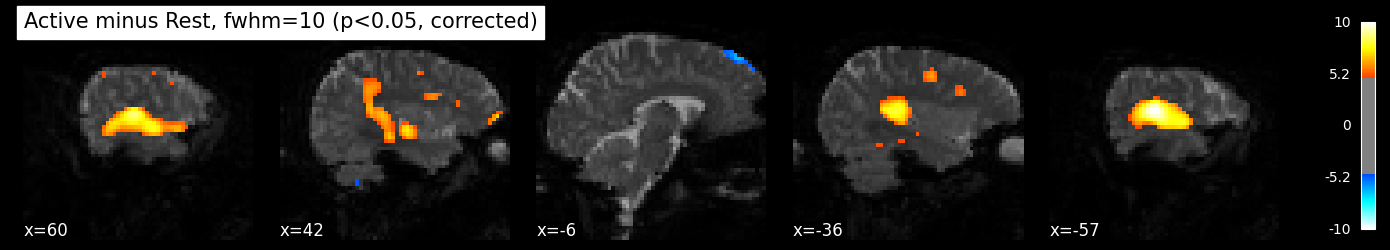

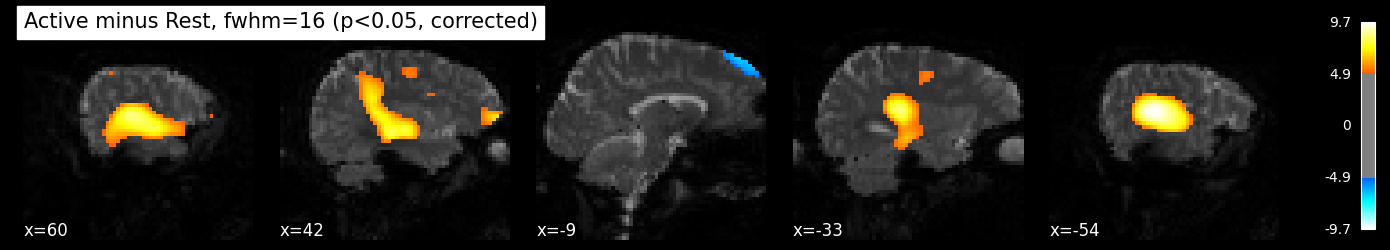

In [ ]:
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map

# Compute the contrast for each smoothed image
z_map_4 = fmri_glm.fit(smoothed_img_4, events).compute_contrast(active_minus_rest, output_type="z_score")
z_map_10 = fmri_glm.fit(smoothed_img_10, events).compute_contrast(active_minus_rest, output_type="z_score")
z_map_16 = fmri_glm.fit(smoothed_img_16, events).compute_contrast(active_minus_rest, output_type="z_score")

# Determine the threshold for each contrast map
_, threshold_4 = threshold_stats_img(z_map_4, alpha=0.05, height_control="bonferroni")
_, threshold_10 = threshold_stats_img(z_map_10, alpha=0.05, height_control="bonferroni")
_, threshold_16 = threshold_stats_img(z_map_16, alpha=0.05, height_control="bonferroni")

# Plot the contrast maps
plot_stat_map(
    z_map_4,
    bg_img=mean_img,
    threshold=threshold_4,
    display_mode="x",
    cut_coords=5,
    black_bg=True,
    title="Active minus Rest, fwhm=4 (p<0.05, corrected)",
)
plt.show()

plot_stat_map(
    z_map_10,
    bg_img=mean_img,
    threshold=threshold_10,
    display_mode="x",
    cut_coords=5,
    black_bg=True,
    title="Active minus Rest, fwhm=10 (p<0.05, corrected)",
)
plt.show()

plot_stat_map(
    z_map_16,
    bg_img=mean_img,
    threshold=threshold_16,
    display_mode="x",
    cut_coords=5,
    black_bg=True,
    title="Active minus Rest, fwhm=16 (p<0.05, corrected)",
)
plt.show()


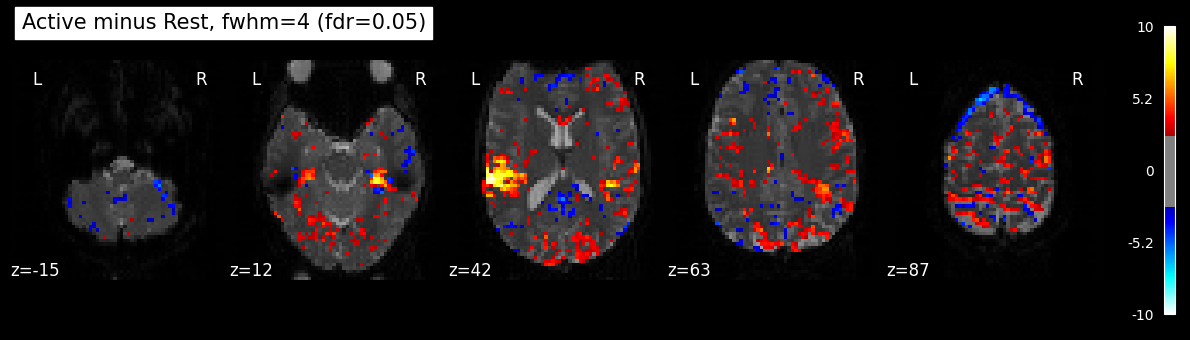

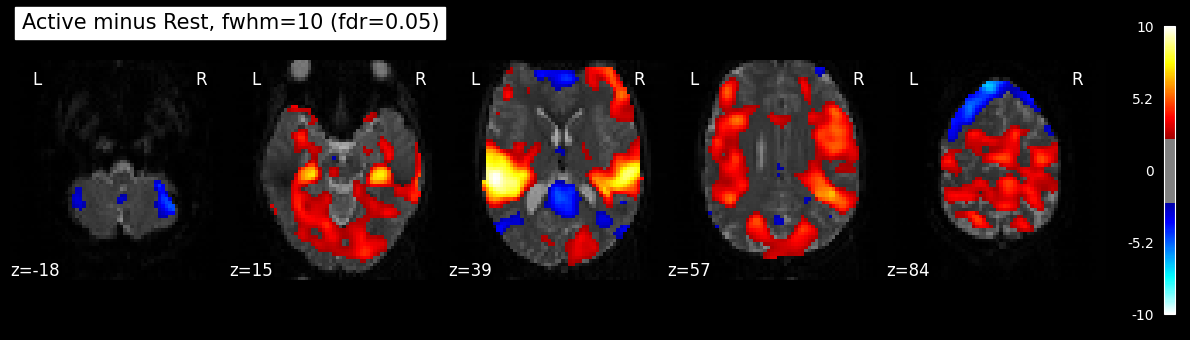

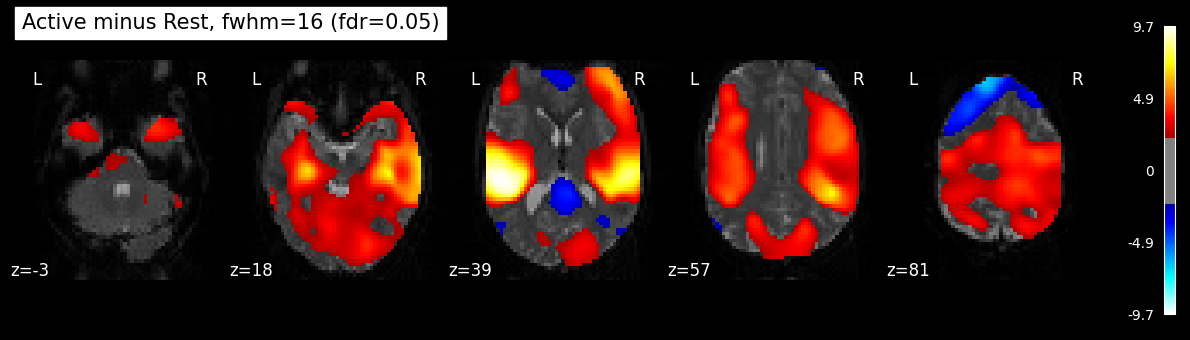

In [ ]:
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map

# Compute the contrast for each smoothed image
z_map_4 = fmri_glm.fit(smoothed_img_4, events).compute_contrast(active_minus_rest, output_type="z_score")
z_map_10 = fmri_glm.fit(smoothed_img_10, events).compute_contrast(active_minus_rest, output_type="z_score")
z_map_16 = fmri_glm.fit(smoothed_img_16, events).compute_contrast(active_minus_rest, output_type="z_score")

# Determine the threshold for each contrast map
_, threshold_4 = threshold_stats_img(z_map_4, alpha=0.05, height_control="fdr")
_, threshold_10 = threshold_stats_img(z_map_10, alpha=0.05, height_control="fdr")
_, threshold_16 = threshold_stats_img(z_map_16, alpha=0.05, height_control="fdr")

# Plot the contrast maps
plot_stat_map(
    z_map_4,
    bg_img=mean_img,
    threshold=threshold_4,
    display_mode="z",
    cut_coords=5,
    black_bg=True,
    title="Active minus Rest, fwhm=4 (fdr=0.05)",
)
plt.show()

plot_stat_map(
    z_map_10,
    bg_img=mean_img,
    threshold=threshold_10,
    display_mode="z",
    cut_coords=5,
    black_bg=True,
    title="Active minus Rest, fwhm=10 (fdr=0.05)",
)
plt.show()

plot_stat_map(
    z_map_16,
    bg_img=mean_img,
    threshold=threshold_16,
    display_mode="z",
    cut_coords=5,
    black_bg=True,
    title="Active minus Rest, fwhm=16 (fdr=0.05)",
)
plt.show()


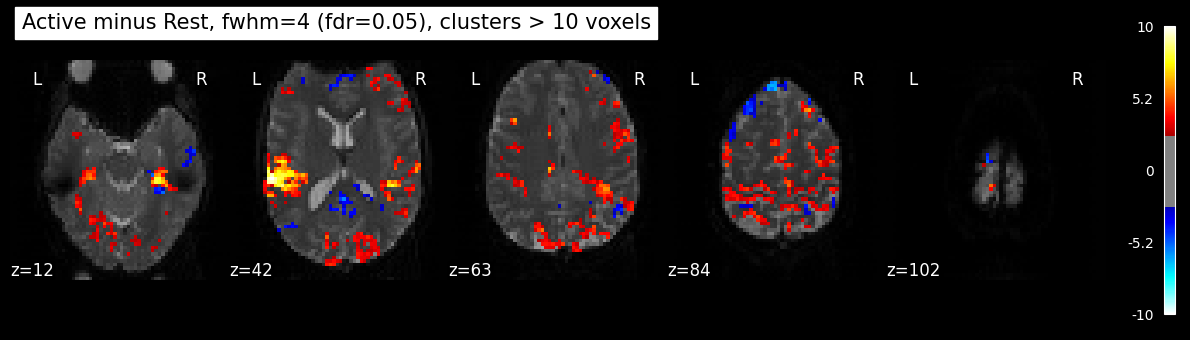

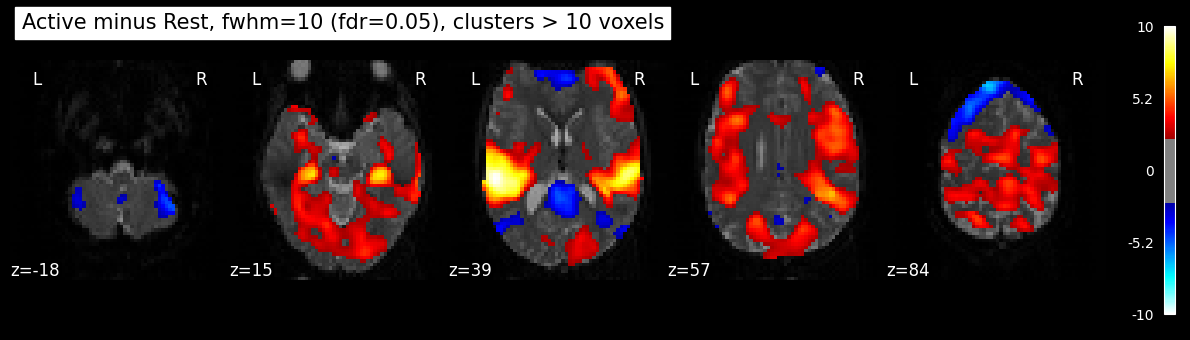

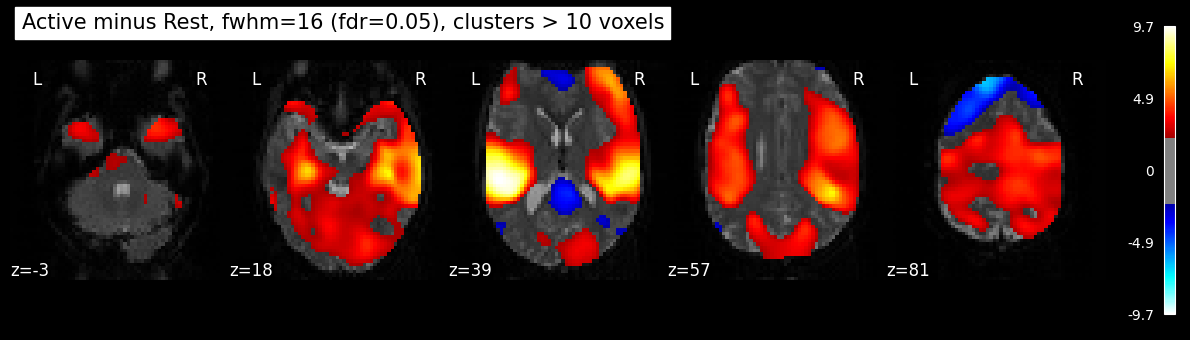

In [ ]:
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map

# Compute the contrast for each smoothed image
z_map_4 = fmri_glm.fit(smoothed_img_4, events).compute_contrast(active_minus_rest, output_type="z_score")
z_map_10 = fmri_glm.fit(smoothed_img_10, events).compute_contrast(active_minus_rest, output_type="z_score")
z_map_16 = fmri_glm.fit(smoothed_img_16, events).compute_contrast(active_minus_rest, output_type="z_score")

# Determine the threshold for each contrast map and apply cluster threshold
clean_map_4, threshold_4 = threshold_stats_img(z_map_4, alpha=0.05, height_control="fdr", cluster_threshold=10)
clean_map_10, threshold_10 = threshold_stats_img(z_map_10, alpha=0.05, height_control="fdr", cluster_threshold=10)
clean_map_16, threshold_16 = threshold_stats_img(z_map_16, alpha=0.05, height_control="fdr", cluster_threshold=10)

# Plot the contrast maps
plot_stat_map(
    clean_map_4,
    bg_img=mean_img,
    threshold=threshold_4,
    display_mode="z",
    cut_coords=5,
    black_bg=True,
    title="Active minus Rest, fwhm=4 (fdr=0.05), clusters > 10 voxels",
)
plt.show()

plot_stat_map(
    clean_map_10,
    bg_img=mean_img,
    threshold=threshold_10,
    display_mode="z",
    cut_coords=5,
    black_bg=True,
    title="Active minus Rest, fwhm=10 (fdr=0.05), clusters > 10 voxels",
)
plt.show()

plot_stat_map(
    clean_map_16,
    bg_img=mean_img,
    threshold=threshold_16,
    display_mode="z",
    cut_coords=5,
    black_bg=True,
    title="Active minus Rest, fwhm=16 (fdr=0.05), clusters > 10 voxels",
)
plt.show()


For all of the following we just applied the previous methods of detection with our new smoothed time series.
From the results, we clearly see that the higher the fmwh is in our modified time series the more spread out the areas of activation are.
For every method when looking at smooth time series when fwhm = 4, the areas of activation are relatively localized and distinct unlike the case where fhwm is equal to 16.

by plotting again and comparing our different results we can also say that the bonferroni method is quite conservative in comparaison of other methods, with fewer areas of the brain being highlighted as significantly activated.

In [ ]:
#because using google colab i want to convert it in html
%%shell
jupyter nbconvert --to html /content/Neurology_TomLG.ipynb